# Homework 2

We first load the libraries needed.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

from scipy.stats import t

## 1. Get the information needed to extract data

We then send a request on the page base_all_gps and use BeautifulSoup to analyze the html page in order to find all the informations we need to solve the exercise.

In [2]:
base_all_gps='http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&zz_x_UNITE_ACAD=Informatique&ww_x_UNITE_ACAD=249847'
r = requests.get(base_all_gps)

In [30]:
#r.text

The three following lists consider the items we want to consider for our study.

In [3]:
semester_bachelor=['Bachelor semestre 1','Bachelor semestre 2','Bachelor semestre 3','Bachelor semestre 4','Bachelor semestre 5','Bachelor semestre 6']
semester_master=['Master semestre 1','Master semestre 2','Master semestre 3','Projet Master automne','Projet Master printemps']
years=['2007-2008','2008-2009','2009-2010','2010-2011','2011-2012','2012-2013','2013-2014','2014-2015','2015-2016','2016-2017']

We generate a dictionary that will help us to load the dataframe to analyse the data.

In [4]:
# Generate dictionary
main_dictionary={}
for year in years:
    main_dictionary[year]=dict()
    for item in semester_bachelor:
        main_dictionary[year][item]=0
    for item in semester_master:
        main_dictionary[year][item]=0
    

We use beautiful soup to read the html file.

In [5]:
soup=BeautifulSoup(r.text, "lxml")

Now we want to find the ids corresponding to the periode_academique of every year. 

In [6]:
# Parse the parameter "periode_academique"
parse_years=soup.find_all('option')

for year in main_dictionary:
    for item in parse_years:
        if year==item.string:
            main_dictionary[year]['periode_academique']=item.get('value')

Now we want to find all the GPS ids. We only want the GPS of the elements whose values are either "Informatique", "Master" or "Bachelor". In the html file, we have seen that the informations we want are in the blocks called "a". 

In [7]:
tag=soup.body
gps_list=tag.find_all('a')

In [8]:
# Hard preprocessing to fast eliminate the unwanted strings
gps_processed=[]
key1='Informatique'
key2='Bachelor'
key3='Master'
for i in gps_list:
    if key1 in i.contents[0] and (key2 in i.contents[0] or key3 in i.contents[0]):
        gps_processed.append(i)

In [9]:
# Keep only the right entries, and add the GPS ids in the main_dictionary
for year in main_dictionary:
    for semester in main_dictionary[year]:
        for item in gps_processed:
            if 'Informatique, '+year+', '+semester==item.contents[0]:
                # We determine which value corresponds to the GPS from the string item.
                gps=str(item).split("'")[1].split("=")[1]
                main_dictionary[year][semester]=gps
print(main_dictionary)

{'2007-2008': {'Bachelor semestre 4': '39494823', 'Bachelor semestre 1': '71297531', 'Projet Master printemps': '39495444', 'Master semestre 3': '39495424', 'Bachelor semestre 5': '19561980', 'Projet Master automne': '39495382', 'periode_academique': '978181', 'Bachelor semestre 6': '19561998', 'Master semestre 2': '71450725', 'Bachelor semestre 2': '71297550', 'Master semestre 1': '71450699', 'Bachelor semestre 3': '39494788'}, '2009-2010': {'Bachelor semestre 4': '109576992', 'Bachelor semestre 1': '213617925', 'Projet Master printemps': '109592400', 'Master semestre 3': '109592375', 'Bachelor semestre 5': '71297605', 'Projet Master automne': '109592334', 'periode_academique': '978195', 'Bachelor semestre 6': '71297626', 'Master semestre 2': '213629869', 'Bachelor semestre 2': '213617944', 'Master semestre 1': '213629838', 'Bachelor semestre 3': '109576974'}, '2015-2016': {'Bachelor semestre 4': '1744377976', 'Bachelor semestre 1': '1897032870', 'Projet Master printemps': '1745490504

# 2. Get the tables
From a base request, we consider the parameters for each page we want to load, both from the url considered before (base_all_gps) and from the dictionary we have just built. Then we load the page, and take the data from it. 

In [10]:
base_request='http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html'

We first set www_x_PERIODE_ACAD and ww_x_GPS to 0 since those fields will change depending on the page we are considering. 

In [11]:
parameters={'ww_i_reportModel':'133685247','ww_i_reportModelXsl':'133685270',
            'ww_x_UNITE_ACAD':'249847','ww_x_PERIODE_ACAD':0,'ww_x_GPS':0}

Two dictionaries of dictionaries of dataframes are created (indexed by the year and the academic period), one for the bachelor data, and one for the master data, each of which contains the data of a given semester.

In [12]:
bachelor_data={x:dict() for x in main_dictionary}
master_data={x:dict() for x in main_dictionary}
for year in main_dictionary:
    # Set the right academic period
    parameters['ww_x_PERIODE_ACAD']=main_dictionary[year]['periode_academique']
    for semester in main_dictionary[year]:
        if semester=='periode_academique':
            continue
        # Set the right GPS
        parameters['ww_x_GPS']=main_dictionary[year][semester]
        
        # Post the request
        req = requests.get(base_request,params=parameters)
        
        # Import and process the dataframe with pandas
        try:
            df=pd.read_html(str(req.text),skiprows=1,header=0)[0]
            # Name columns
            df.columns=['Sex','Name','OrienB','OrienM','Specialization','Unuseful1','Mineur','State','Exchange','ExchangeSchool','Sciper','Unuseful2']
            # Delete useless columns
            del df['OrienB'],df['OrienM'],df['Unuseful1'],df['State'],df['Exchange'],df['ExchangeSchool'],df['Unuseful2']
            # Add the column year
            df['Year']=year
        except:
            # If something went wrong.
            df=pd.DataFrame({'Sex':[],'Name':[],'Specialization':[],'Mineur':[],'Sciper':[],'Year':[]})
        
        # Type semester can be 'Bachelor' or 'Master'. 
        type_semester=semester.split(' ')[0]
        if type_semester=='Projet':
            type_semester='Master'
            
        # Semester number is the number of the current semester. It is 4 for master projects.
        semester_number=-1
        if semester!='Projet Master automne' and semester!='Projet Master printemps':
            semester_number=int(semester.split(' ')[2])
        else:
            semester_number=4
        df['Semester']=semester_number
        df=df.set_index(['Sciper','Year','Semester'])

        # Set the data in the right dictionnary.
        if type_semester=="Bachelor":
            bachelor_data[year][semester_number]=df
        elif type_semester=="Master":
            master_data[year][semester_number]=df
        else:
            print(type_semester)
            raise("Error parsing file: type semester not acceptable")
    print("Year "+year+" parsed")

Year 2007-2008 parsed
Year 2009-2010 parsed
Year 2015-2016 parsed
Year 2013-2014 parsed
Year 2014-2015 parsed
Year 2016-2017 parsed
Year 2011-2012 parsed
Year 2012-2013 parsed
Year 2010-2011 parsed
Year 2008-2009 parsed


In [13]:
# Check the correct parsing of all the semesters
bachelor_data_semesters=0
master_data_semesters=0
for year in master_data:
    master_data_semesters+=len(master_data[year])
for year in bachelor_data:
    bachelor_data_semesters+=len(bachelor_data[year])
if (bachelor_data_semesters+master_data_semesters!=100):
    raise("Some semester has not been correctly parsed")

# Bachelor analysis
We here analyse the bachelor data. From the dictionary of dictionaries bachelor_data, we concatenate all the informations to form a unique dataframe. We then group it by Sciper to have all the information for each individual student without repetitions.

In [14]:
bachelor_tables=[]
for year in bachelor_data:
    for semester in bachelor_data[year]:
        bachelor_tables.append(bachelor_data[year][semester])
total_bachelor=pd.concat(bachelor_tables,axis=0,join='outer')
total_bachelor=total_bachelor.reset_index()
groups_bachelor=total_bachelor.groupby('Sciper')

In [15]:
final_df_bachelor=pd.DataFrame({'Sciper':[],'Name':[],'Sex':[],'Semesters':[]})

for student,group in groups_bachelor:
    first_year=group['Semester'].isin([1]).sum() #It is the number of times a student has
    #done bachelor 1
    last_year=group['Semester'].isin([6]).sum() #It is the number of times a student has
    #done bachelor 6
    year=int(group['Year'].min()[:4]) # We only consider the first four characters of the
    #year, so that we have just one year and not  (ex: 2010 instead of 2010-2011), and we 
    #take the minimum to know in which year each student began its bachelor studies at EPFL.
    
    if first_year and last_year:
        number_of_years=group.shape[0] # This corresponds to the number of times a certain
        #sciper appears, that it the number of semester a student has done. 
        name=group['Name'].iloc[0]
        sex=group['Sex'].iloc[0]
        if sex=="Monsieur":
            sex='M'
        elif sex=="Madame":
            sex='F'
        else:
            raise("Not existing sex")
        # We create a unique dataframe where each student appear only once, containing 
        # only the informations that interest us.
        ser=pd.DataFrame({'Sciper':[student],'Name':[name],'Sex':[sex],'Semesters':[number_of_years],'Year':[year]})
        final_df_bachelor=final_df_bachelor.append(ser)
    
final_df_bachelor=final_df_bachelor.set_index('Sciper')
final_df_bachelor.head()

,Name,Semesters,Sex,Year
Sciper,,,,
147008.0,Good Xavier,6.0,M,2008.0
169569.0,Arévalo Christian,6.0,M,2007.0
169731.0,Knecht Mathieu,8.0,M,2007.0
169795.0,Scheiben Pascal,9.0,M,2007.0
171195.0,Richter Arnaud,6.0,M,2007.0


Now, our aim is to know if there is a statistically significant difference between males and females about the time they take to finish their bachelor studies. To do so, we first group our data by Sex.

In [16]:
final_df_bachelor_bysex = final_df_bachelor[['Sex','Semesters']].groupby(['Sex'])
final_df_bachelor_meansex = final_df_bachelor_bysex.mean()
final_df_bachelor_meansex

,Semesters
Sex,
F,6.793103
M,7.105978


Then we have a general overlook at the data distribution per gender. In the following the boxplots for males and females are reported.

OrderedDict([('F', <matplotlib.axes._subplots.AxesSubplot at 0xb7c9ba8>),
             ('M', <matplotlib.axes._subplots.AxesSubplot at 0xc8241d0>)])

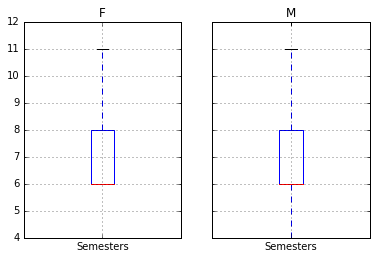

In [40]:
# have a look at the tabular data
#final_df_bachelor_bysex.describe()
final_df_bachelor_bysex.boxplot(column = 'Semesters',return_type='axes')

We notice that both genders seem to follow the same distribution, which is highly concentrated at the expected value 6 (that is, 3 regular years to complete the bachelor) and then shows a heavy tail towards greater values. Despite this antisymmetric behaviour, we treat the data as normally distributed, in order to perform a statistical test for the means of the two populations. Fitting the data with another distribution (such as an exponential, for instance), would increase indeed the complexity of the test.

We perform now a two sample t-test to find if there is any statistically significant difference between the time women and men take to complete the bachelor.

In [17]:
#Male data
male_mean=final_df_bachelor_bysex.mean().iloc[1]
male_std=final_df_bachelor_bysex.std().iloc[1]
male_count=final_df_bachelor_bysex.count().iloc[1]
#Female data
female_mean=final_df_bachelor_bysex.mean().iloc[0]
female_std=final_df_bachelor_bysex.std().iloc[0]
female_count=final_df_bachelor_bysex.count().iloc[0]
#Output dataframe
output=pd.DataFrame()

#Computation of the t-test and the p-value
nu=male_count+female_count-2
output['t-test']=(male_mean-female_mean)/(male_std*male_std/male_count+female_std*female_std/female_count)
output['p-value']=t.sf(abs(output['t-test'].reshape([output['t-test'].shape[0],1])),nu)*2
output

,t-test,p-value
Semesters,4.539076,0.000008


**Conclusion:** There is a statistically significant difference between male and female about the time it takes them to complete their bachelor, since 0.000008 << 0.05.

We group now the dataframe describing bachelor data into sex and year the student has begun its studies. This will allow us to plot the evolution of the number of semesters taken to finish one's bachelor, over time.

In [18]:
final_df_bachelor_grouped = final_df_bachelor[['Year','Sex','Semesters']].groupby(['Year','Sex'])
final_df_bachelor_grouped.describe()

Semesters
Year   Sex                 
2007.0 F   count   2.000000
           mean    6.000000
           std     0.000000
           min     6.000000
           25%     6.000000
           50%     6.000000
           75%     6.000000
           max     6.000000
       M   count  39.000000
           mean    6.974359
           std     1.366655
           min     6.000000
           25%     6.000000
           50%     6.000000
           75%     8.000000
           max    12.000000
2008.0 F   count   5.000000
           mean    6.600000
           std     1.341641
           min     6.000000
           25%     6.000000
           50%     6.000000
           75%     6.000000
           max     9.000000
       M   count  38.000000
           mean    7.210526
           std     1.679091
           min     6.000000
           25%     6.000000
           50%     6.000000
...                     ...
2013.0 F   std     0.816497
           min     6.000000
           25%     6.000000
           50%     6.000000
           75%     6.000000
           max     8.000000
       M   count  41.000000
           mean    6.219512
           std     0.419058
           min     6.000000
           25%     6.000000
           50%     6.000000
           75%     6.000000
           max     7.000000
2014.0 F   count   1.000000
           mean    6.000000
           std          NaN
           min     6.000000
           25%     6.000000
           50%     6.000000
           75%     6.000000
           max     6.000000
       M   count  20.000000
           mean    6.000000
           std     0.000000
           min     6.000000
           25%     6.000000
           50%     6.000000
           75%     6.000000
           max     6.000000

[128 rows x 1 columns]

In [30]:
df_bachelor_mean = final_df_bachelor_grouped.mean()
df_bachelor_mean

Semesters
Year   Sex           
2007.0 F     6.000000
       M     6.974359
2008.0 F     6.600000
       M     7.210526
2009.0 F     7.000000
       M     7.813953
2010.0 F     6.000000
       M     7.290909
2011.0 F     7.250000
       M     7.553571
2012.0 F     8.000000
       M     7.026316
2013.0 F     6.333333
       M     6.219512
2014.0 F     6.000000
       M     6.000000

## Scatterplot, bonus question
We plot the number of semesters each students has done to complete the bachelor, depending on its sex and on the year he/she has begun its studies. Note that this result is biased since we consider very few years. Indeed, since we do not look at any year after 2016, then for sure we suppose that the students present in bachelor 6 in 2016 will finish in 2016 and will not continue with a bachelor 5 afterwards, as it would be possible. As a consequence, the later they have began their studies, the less time we "let them" to compute their bachelor. And consequently, the results are biased towards a lower mean time of studies when approaching 2016. 

In [31]:
df_bachelor_mean

Semesters
Year   Sex           
2007.0 F     6.000000
       M     6.974359
2008.0 F     6.600000
       M     7.210526
2009.0 F     7.000000
       M     7.813953
2010.0 F     6.000000
       M     7.290909
2011.0 F     7.250000
       M     7.553571
2012.0 F     8.000000
       M     7.026316
2013.0 F     6.333333
       M     6.219512
2014.0 F     6.000000
       M     6.000000

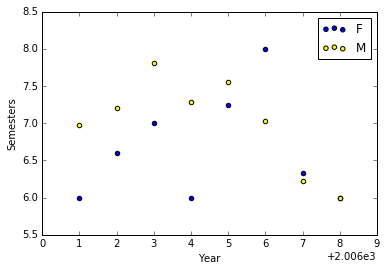

In [32]:
#print(ax)
df_bachelor_mean.reset_index(level=0, inplace=True)
ax = df_bachelor_mean.loc['F'].plot(x='Year', y='Semesters', color='Blue', label='F', kind='scatter')
df_bachelor_mean.loc['M'].plot.scatter(x='Year', y='Semesters', color='Yellow', label='M', ax=ax)

**Conclusion:** From this scatterplot, it seems that males generally take more time than females to finish their bachelor. This is in accordance with what we got with the t-test.

# Master analysis
We now analyse Master data in the same way as for bachelor. From the dictionary of dictionaries master_data, we concatenate all the informations to form a unique dataframe. We then group it by Sciper to have all the information for each individual student without repetitions.

In [26]:
master_tables=[]
for year in master_data:
    for semester in master_data[year]:
        master_tables.append(master_data[year][semester])
total_master=pd.concat(master_tables,axis=0,join='outer')
total_master=total_master.reset_index()
groups_master=total_master.groupby('Sciper')

In [27]:
final_df_master=pd.DataFrame({'Sciper':[],'Name':[],'Sex':[],'Semesters':[],'Specialization':[]})

for student,group in groups_master:
    # Store the check variables, i.e. find how many times a student has done the 1st-... 
    # semesters, master project or mineur. Nan are always replaced to consider them
    # carefully depending on what they mean (ex: Nan in Mineur means the student has not
    # done any minor). 
    first_semester=group['Semester'].isin([1]).sum()
    second_semester=group['Semester'].isin([2]).sum()
    third_semester=group['Semester'].isin([3]).sum()
    master_project_done=group['Semester'].isin([4]).sum()
    mineur=group['Mineur'].fillna('').sum()!=''
    specialization=group.Specialization.fillna(method='backfill').fillna(method='pad').fillna('').iloc[0]    
    year=int(group['Year'].min()[:4])

    # Store only the students with:
    #   - first_semester and master_project_done
    #   - first_semester and third_semester 
    #   - first_semester and second_semester and not mineur
    check1=first_semester and master_project_done
    check2=first_semester and third_semester
    check3=first_semester and second_semester and not mineur
    
    if check1 or check2 or check3:
        number_of_years=group.shape[0] # This corresponds to the number of times a certain
        #sciper appears, that it the number of semester a student has done. 
        name=group['Name'].iloc[0]
        sex=group['Sex'].iloc[0]
        if sex=="Monsieur":
            sex='M'
        elif sex=="Madame":
            sex='F'
        else:
            raise("Not existing sex")
        # We create a unique dataframe where each student appear only once, containing 
        # only the informations that interest us.
        ser=pd.DataFrame({'Sciper':[student],'Name':[name],'Sex':[sex],'Semesters':[number_of_years],
                         'Specialization':[specialization],'Year':[year]})
        final_df_master=final_df_master.append(ser)
    
final_df_master=final_df_master.set_index('Sciper')
final_df_master.head()

,Name,Semesters,Sex,Specialization,Year
Sciper,,,,,
146330.0,Cardinaux Damien,3.0,M,,2007.0
146742.0,Marx Clément,6.0,M,"Signals, Images and Interfaces",2008.0
146929.0,Junod Antoine,2.0,M,,2007.0
147008.0,Good Xavier,4.0,M,"Signals, Images and Interfaces",2011.0
152232.0,Anagnostaras David,3.0,M,,2007.0


In [29]:
avg_stay = final_df_master['Semesters'].mean()
print('The mean average stay in master at EPFL is of '+str(avg_stay)+' semesters.')

The mean average stay in master at EPFL is of 3.3503937007874014 semesters.


We group now the dataframe describing master data into sex and year the student has begun its studies. This will allow us to plot the evolution of the number of semesters taken to finish one's master, over time.

In [30]:
final_df_master_grouped = final_df_master[['Year','Sex','Semesters']].groupby(['Year','Sex'])
df_master_mean=final_df_master_grouped.mean()
df_master_mean

Semesters
Year   Sex           
2007.0 F     2.600000
       M     3.112903
2008.0 F     3.333333
       M     2.866667
2009.0 F     3.333333
       M     3.255319
2010.0 F     3.615385
       M     3.333333
2011.0 F     3.312500
       M     3.368421
2012.0 F     3.583333
       M     3.478873
2013.0 F     3.357143
       M     3.530120
2014.0 F     4.076923
       M     4.033333
2015.0 F     3.000000
       M     2.917431

## Scatterplot, bonus question
We plot the number of semesters each students has done to complete the master, depending on its sex and on the year he/she has begun its studies. For more remarks, see the details of the Scatterplot for the bachelor studies, which has been done in the same way.

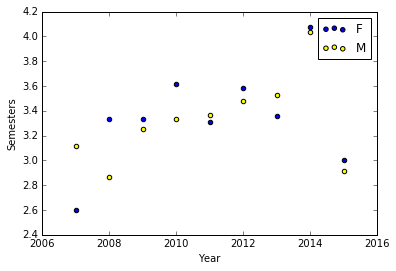

In [31]:
df_master_mean.reset_index(level=0, inplace=True)
ax = df_master_mean.loc['F'].plot(x='Year', y='Semesters', color='Blue', label='F', kind='scatter')
df_master_mean.loc['M'].plot.scatter(x='Year', y='Semesters', color='Yellow', label='M', ax=ax)

**Conclusion:** It does not seem to be a real difference between male and females regarding the time they take to finish their Master. This could be confirmed with a t-test as performed for the bachelor analysis (it would be exaclty the same code).

And then we group the students by specialization to know how many of them have done which specialization.

In [32]:
specialization_analysis=final_df_master[['Semesters','Specialization']].groupby('Specialization')
specialization_analysis.count() #It shows the number of students having done this specialization.

,Semesters
Specialization,
,519
Biocomputing,4
Computer Engineering - SP,20
Computer Science Theory,1
Data Analytics,6
Foundations of Software,62
Information Security - SP,7
Internet Information Systems,1
Internet computing,91


In [33]:
specialization_analysis.mean()

,Semesters
Specialization,
,3.136802
Biocomputing,4.000000
Computer Engineering - SP,3.700000
Computer Science Theory,3.000000
Data Analytics,2.833333
Foundations of Software,3.935484
Information Security - SP,3.571429
Internet Information Systems,3.000000
Internet computing,3.824176


We now perform a two sample t-test to find if there is any specialization for which the difference of study time (in number of semesters) is in average statistically significant. This means that we want to know if students significantly take more (or less) time to complete one of the specializations. We note that there is only one student that has chosen "Computer Science Theory" and "Internet Information Systems" as specialization. For those two, we can then not compute the t-test, and thus not the p-value.

In [34]:
specialization_mean=specialization_analysis.mean()
specialization_std=specialization_analysis.std()
specialization_count=specialization_analysis.count()
output=specialization_analysis.mean()
base_mean=specialization_mean.iloc[0]
base_std=specialization_std.iloc[0]
base_count=specialization_count.iloc[0]

nu=specialization_count+base_count-2
output['t-test']=(specialization_mean-base_mean)/(specialization_std*specialization_std/specialization_count+base_std*base_std/base_count)
output['p-value']=t.sf(abs(output['t-test'].reshape([output['t-test'].shape[0],1])),nu)*2
output

,Semesters,t-test,p-value
Specialization,,,
,3.136802,0.000000,1.000000e+00
Biocomputing,4.000000,2.577078,1.023787e-02
Computer Engineering - SP,3.700000,14.445601,3.386185e-40
Computer Science Theory,3.000000,NaN,NaN
Data Analytics,2.833333,-10.323138,7.293080e-23
Foundations of Software,3.935484,42.031559,4.851378e-178
Information Security - SP,3.571429,3.156939,1.686109e-03
Internet Information Systems,3.000000,NaN,NaN
Internet computing,3.824176,53.898859,9.293679e-234


**Conclusion:** Every p-value is below 0.05, which means that there is a statistically significant difference between the mean number of semester done by the students and the number of semesters performed by the students having chosen different specialization.